### ENTRENAMIENTO DEL MODELO STUDENT MOBILENETV3 SMALL

Importar Librerias necesarias

In [1]:
import os
import numpy as np
import torchvision  
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import timm  # Library con modelos SOTA, incluidos ViT
import time, copy
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small
import torch.nn.functional as F
import copy
import time
from tqdm import tqdm
import pickle

#Funciones generales para analizar resultados y métricas
from src.eval_utils import visualizar_curvas, evaluar_modelo, medir_inferencia


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ETAPA 1 PREPROCESAMIENTO, APLICACIÓN DE TÉCNICAS - TRANSFORMERS

In [5]:
#Especificar el dispositivo para el entorno de trabajo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Funciones adicionales utlizadas como técnicas para mejorar la generalización
(Nota: estas funciones se las utilizó como parte de las pruebas, no usadas para el modelo final PILGaussianBlur, Cutout)

In [6]:
#ULTIMA MODIFICACION PARA MEJORAR LA GENERALIZACION (U1)
from PIL import ImageFilter
import random
import numpy as np
import torch

# Filtro de desenfoque Gaussiano (suaviza detalles irrelevantes)
class PILGaussianBlur:
    def __init__(self, radius=1.2):
        self.radius = radius
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

# Cutout: elimina una región cuadrada aleatoria
class Cutout:
    def __init__(self, mask_size=40, p=0.5, replace=0):
        self.mask_size = mask_size
        self.p = p
        self.replace = replace

    def __call__(self, img):
        if random.uniform(0, 1) > self.p:
            return img

        h, w = img.shape[1], img.shape[2]
        y = random.randint(0, h)
        x = random.randint(0, w)

        y1 = np.clip(y - self.mask_size // 2, 0, h)
        y2 = np.clip(y + self.mask_size // 2, 0, h)
        x1 = np.clip(x - self.mask_size // 2, 0, w)
        x2 = np.clip(x + self.mask_size // 2, 0, w)

        img[:, y1:y2, x1:x2] = self.replace
        return img


#### Preprocesamiento
Definir rutas y transformaciones, se define las técnicas que seran aplicadas para el entrenamiento , con la finalidad de que el modelo generalice, evitar un sobreajuste, y consusión entre clases. (El transform definido en el siguiente bloque se lo utilizón para todos los casos de entrenamiento excepto el final que incorpora una Configuración y SPLIT 80/15/5 reproducible)

In [7]:
# Ruta al dataset
data_path = 'TFM/food-101/food-101/images/'
# Clase para añadir ruido gaussiano
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean
        
# Transformaciones con técnicas avanzadas de data augmentation
transform_train = transforms.Compose([
    #PILGaussianBlur(radius=1.2),  # Suavizado previo, AUMENTADO POR U1
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),    
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0)),  # ← APLICAR DESENFOQUE
    transforms.ToTensor(),
    #AddGaussianNoise(0., 0.05),
    #Cutout(mask_size=40, p=0.5),  # Regularización, , AUMENTADO POR U1
    #transforms.RandomErasing(p=0.2), #Aplicacion inicial
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # ← BORRAR ALEATORIAMENTE cambio por cutmix
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##### PARTICIÓN DE DATOS
Partición del conjuntode datos inicialmente 70/15/15 configuración típica, posterior se aplica 80/15/5:

Validación: para afinar hiperparámetros, evitar overfitting (durante el entrenamiento).

Test: para evaluación final, como si el modelo nunca hubiera visto esos datos.

In [8]:
# Dataset original con transformaciones de entrenamiento
full_dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

# División 70% train, 15% val, 15% test
total_size = len(full_dataset)
train_size = int(0.80 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Aplicar Transformaciones para val y test
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Clases
class_names = full_dataset.classes
print("Clases:", class_names)
print("Tamalo Clases:", len(class_names))

Clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', '

In [9]:
# Diccionario de dataloaders y tamaños
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

Visualizar algunas imágenes con las técnicas aplicadas (transformers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].


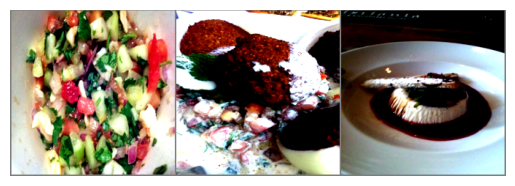

Etiquetas: ['ceviche', 'falafel', 'panna_cotta']


In [10]:
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Mostrar una tanda de imágenes
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:3]))
print('Etiquetas:', [class_names[i] for i in labels[:3]])

Visualizar distribución de clases y algunas imágenes

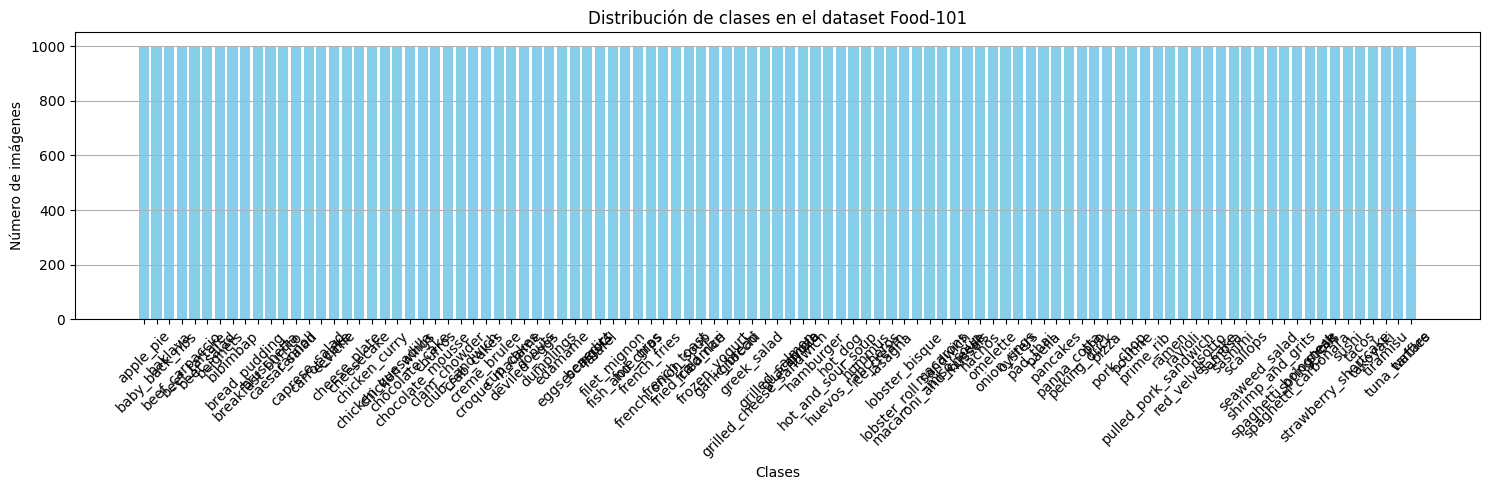

In [12]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# Ruta a tus datos
dataset_path = data_path

# Obtener clases y conteo por clase
classes = os.listdir(dataset_path)
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))  # Orden alfabético

# Plot de barras: distribución de clases
plt.figure(figsize=(15,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribución de clases en el dataset Food-101")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Todas las clases tienen el mismo numero de muestras, no existe desbalanceo


Mostrar algunas imágenes aleatorias de diferentes clases (ejemplificar imágenes originales)

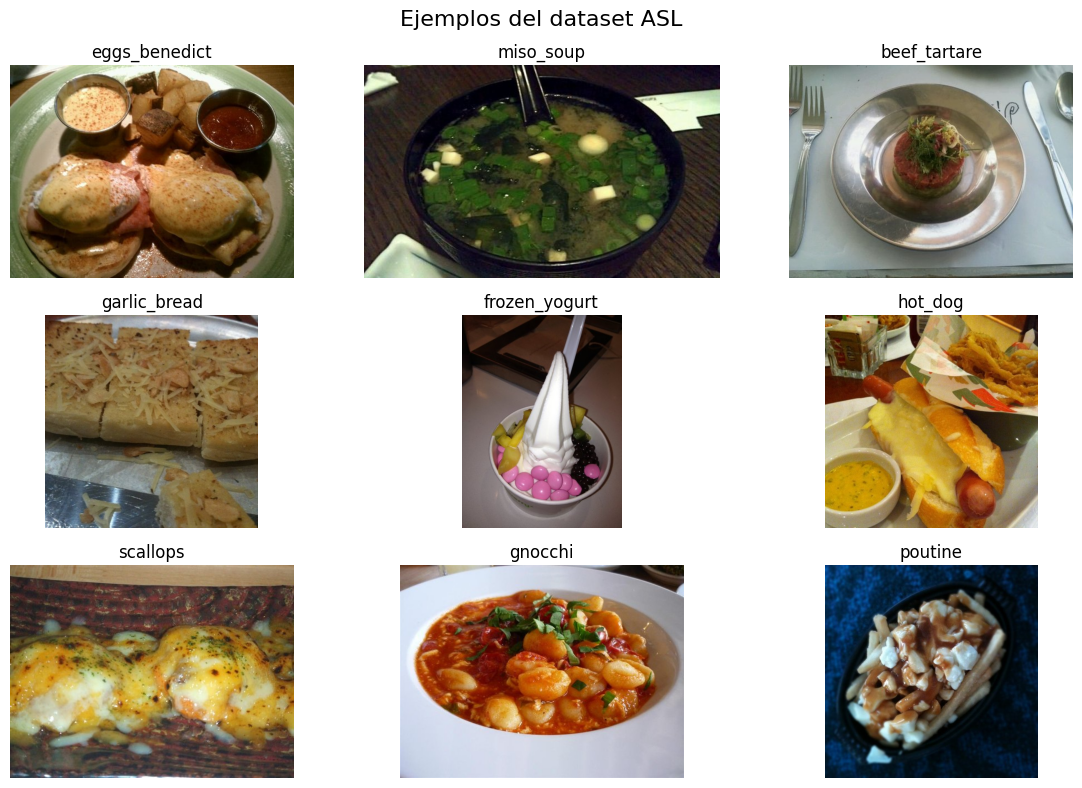

In [12]:
import random

plt.figure(figsize=(12, 8))

for i, cls in enumerate(random.sample(classes, 9)):
    cls_path = os.path.join(dataset_path, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Ejemplos del dataset ASL", fontsize=16)
plt.tight_layout()
plt.show()

### ETAPA 2  Entrenamiento del Modelo Student (MobileNetV3 Small)

Con el fin de garantizar un punto de partida sólido que permitiera evaluar su capacidad de generalización a partir de las configuraciones exitosas obtenidas con el modelo Teacher, se decidió reutilizar las mismas técnicas de aumento de datos, regularización y particionado, asegurando así condiciones comparables y consistentes en la evaluación de resultados.

La función de entrenamiento se reutiliza la que se aplico en ViT Base que entrena el modelo aplicando **CutMix de forma probabilística** 

 Instalar y/o importar dependencias necesarias

In [11]:
#!pip install -q timm

from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import timm  # Library con modelos SOTA, incluidos ViT
import time, copy
import os


#### DEFINICIÓN DEL MODELO STUDENT
Cargar e instanciar el modelo MobileNetV3 Small preentrenado

In [ ]:
#A. Carga del modelo Student (MobileNetV3 Small)
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small

# 101 clases dataset FOD-101
num_classes = len(class_names)

# Crear Modelo MobileNetV3 Small con pesos preentrenados
student_model = mobilenet_v3_small(pretrained=True)

# Reemplazar la capa final (classifier) por una con 101 clases
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, num_classes)

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model = student_model.to(device)


#### Funciones generales aplicadas en el entrenamiento

In [14]:
# Función de entrenamiento con soporte a CutMix aplicando condicional con probabilidad
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience=5, scheduler=None, prob_cutmix=0.3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stop_counter = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\n🟦 Epoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Aplicar CutMix si corresponde
                if phase == 'train' and torch.rand(1).item() < prob_cutmix:
                    inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels)
                else:
                    targets_a, targets_b, lam = labels, labels, 1.0

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if phase == 'train' and lam < 1.0:
                        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                        _, preds = torch.max(outputs, 1)
                        corrects = lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item()
                    else:
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        corrects = torch.sum(preds == labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += corrects

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if scheduler:
                    scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        epoch_duration = time.time() - epoch_start_time
        print(f"⏳ Tiempo de la época {epoch+1}: {epoch_duration:.2f} segundos")

        if early_stop_counter >= patience:
            print("\n⏹ Early stopping activado")
            break

    total_time = time.time() - start_time
    print(f'\n🟩 Entrenamiento completo en {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Mejor accuracy de validación: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


In [13]:
# Clase para aplicar CutMix
import random
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

#Solo para vitabse mejora alpha=0.2 ahora alpha=0.3
def cutmix_data(x, y, alpha=0.3):
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = shuffled_x[:, :, bbx1:bbx2, bby1:bby2]

    y_a, y_b = y, shuffled_y
    return x, y_a, y_b, lam

#### ENTRENAMIENTOS


#### Caso 1: Entrenamiento desde cero o con fine-tuning

Entrenaremos MobileNetV3 Small desde cero o usando pesos preentrenados, adaptando la última capa para la clasificación de las 101 clases de FOD-101.

Entrenamiento estandar. En este primer caso se evaluó el desempeño del modelo MobileNetV3 Small bajo un proceso de fine-tuning de 20 épocas, utilizando una partición del 80% para entrenamiento, 15% para validación y 5% para prueba.


En el siguiente bloque se configuran los elementos principales para entrenar el **modelo Student (MobileNetV3 Small)**:  

- **Función de pérdida (`criterion_student`)**: se utiliza `CrossEntropyLoss`, apropiada para problemas de clasificación multiclase.  
- **Optimizador (`optimizer_student`)**: se emplea `Adam` con tasa de aprendizaje `1e-4`, encargado de ajustar los pesos del modelo.  
- **Scheduler (`scheduler_student`)**: `ReduceLROnPlateau` reduce el *learning rate* a la mitad si la **accuracy de validación** no mejora en 3 épocas consecutivas, ayudando a refinar el aprendizaje y evitar estancamientos.  

Este bloque define la estrategia de optimización y control del entrenamiento del modelo Student.  


In [16]:
#B. Entrenamiento clásico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ✅ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 épocas sin mejora
    verbose=True
)


En siguiente bloque se lleva a cabo el **entrenamiento del modelo Student (MobileNetV3 Small)** utilizando la función `train_model`, con un máximo de 20 épocas, paciencia de 5 para early stopping y el scheduler previamente configurado.  

Al finalizar el entrenamiento:  
- Se **guarda el modelo entrenado** en el archivo `mobilenetv3_student_classic_food.pth`.  
- Se **almacena el historial de métricas** (`train_loss`, `val_loss`, `train_acc`, `val_acc`) en `historial_student_classic_food.pkl`, lo que permite posteriormente **visualizar las curvas de entrenamiento y comparar su rendimiento con otros modelos**.  

In [ ]:
# Entrenar modelo 
student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=20,patience=5,scheduler=scheduler_student, , prob_cutmix = 0.5
)

# Guardar modelo entrenado clásico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food.pth')

# Guardar el historial de métricas (loss y accuracy por época)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food.pkl", "wb") as f:
    pickle.dump(history_student, f)


Resultado Entrenamiento1 (Caso1):

🟦 Epoch 1/20
train Loss: 2.2690 Acc: 0.4471
val Loss: 1.4821 Acc: 0.6139
⏳ Tiempo de la época 1: 224.18 segundos

🟦 Epoch 2/20
train Loss: 1.4808 Acc: 0.6109
val Loss: 1.3019 Acc: 0.6524
⏳ Tiempo de la época 2: 120.93 segundos

🟦 Epoch 3/20
train Loss: 1.2488 Acc: 0.6669
val Loss: 1.2232 Acc: 0.6774
⏳ Tiempo de la época 3: 124.40 segundos

🟦 Epoch 4/20
train Loss: 1.0934 Acc: 0.7040
val Loss: 1.2025 Acc: 0.6850
⏳ Tiempo de la época 4: 121.42 segundos

🟦 Epoch 5/20
train Loss: 0.9750 Acc: 0.7307
val Loss: 1.1737 Acc: 0.6945
⏳ Tiempo de la época 5: 121.61 segundos

🟦 Epoch 6/20
train Loss: 0.8715 Acc: 0.7572
val Loss: 1.1744 Acc: 0.7008
⏳ Tiempo de la época 6: 121.16 segundos

🟦 Epoch 7/20
train Loss: 0.7819 Acc: 0.7796
val Loss: 1.1633 Acc: 0.7038
⏳ Tiempo de la época 7: 123.36 segundos

🟦 Epoch 8/20
train Loss: 0.7062 Acc: 0.7976
val Loss: 1.2104 Acc: 0.7024
⏳ Tiempo de la época 8: 124.52 segundos

🟦 Epoch 9/20
train Loss: 0.6343 Acc: 0.8163
val Loss: 1.2078 Acc: 0.7021
⏳ Tiempo de la época 9: 126.84 segundos

🟦 Epoch 10/20
train Loss: 0.5708 Acc: 0.8304
val Loss: 1.2422 Acc: 0.7013
⏳ Tiempo de la época 10: 131.65 segundos

🟦 Epoch 11/20
train Loss: 0.5183 Acc: 0.8445
val Loss: 1.2967 Acc: 0.7015
⏳ Tiempo de la época 11: 124.10 segundos

🟦 Epoch 12/20
train Loss: 0.3918 Acc: 0.8815
val Loss: 1.3004 Acc: 0.7043
⏳ Tiempo de la época 12: 124.74 segundos

🟦 Epoch 13/20
train Loss: 0.3547 Acc: 0.8931
val Loss: 1.3307 Acc: 0.7007
⏳ Tiempo de la época 13: 121.79 segundos

🟦 Epoch 14/20
train Loss: 0.3244 Acc: 0.9016
val Loss: 1.3910 Acc: 0.6979
⏳ Tiempo de la época 14: 123.49 segundos

🟦 Epoch 15/20
train Loss: 0.3036 Acc: 0.9067
val Loss: 1.4127 Acc: 0.6975
⏳ Tiempo de la época 15: 121.97 segundos

🟦 Epoch 16/20
train Loss: 0.2810 Acc: 0.9135
val Loss: 1.4470 Acc: 0.6962
⏳ Tiempo de la época 16: 121.86 segundos

🟦 Epoch 17/20
train Loss: 0.2310 Acc: 0.9285
val Loss: 1.4571 Acc: 0.6964
⏳ Tiempo de la época 17: 122.76 segundos

⏹ Early stopping activado

🟩 Entrenamiento completo en 36m 41s
Mejor accuracy de validación: 0.7043



#### Caso 2:
Con el objetivo de evaluar el efecto de la técnica CutMix, se ejecutó un segundo experimento en el que esta fue removida, manteniéndose constantes el resto de configuraciones. El modelo se entrenó durante un máximo de 30 épocas, bajo las mismas condiciones de particionado y técnicas de regularización utilizadas previamente. Partición 80/15/5


Se mantiene la misma estrategia de optimización y control del entrenamiento del modelo Student.


In [ ]:
#B. Entrenamiento clásico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ✅ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 épocas sin mejora
    verbose=True
)


A continuación se realiza el entrenamiento nuevamente el **modelo Student (MobileNetV3 Small)**, pero a diferencia del entrenamiento previo se **desactiva la técnica CutMix** (`prob_cutmix=0.0`).  

El objetivo de esta configuración es obtener un **modelo Student clásico sin técnicas adicionales de regularización**, lo que permite usarlo como referencia para evaluar después la **optimización mediante Knowledge Distillation (KD)**.  

Al finalizar el entrenamiento:  
- Se **guarda el modelo entrenado** en `mobilenetv3_student_classic_food.pth`.  
- Se **almacena el historial de métricas** (`train_loss`, `val_loss`, `train_acc`, `val_acc`) en `historial_student_classic_food.pkl`, con el fin de **analizar las curvas de entrenamiento y compararlas contra el modelo optimizado con KD**.  



In [ ]:
# Entrenar modelo 
student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=20,patience=5,scheduler=scheduler_student, prob_cutmix = 0.0
)

# Guardar modelo entrenado clásico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food.pth')

# Guardar el historial de métricas (loss y accuracy por época)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food.pkl", "wb") as f:
    pickle.dump(history_student, f)

Entrenamiento 1 Caso2

🟦 Epoch 1/30 train Loss: 2.2585 Acc: 0.4494 val Loss: 1.5088 Acc: 0.6090 ⏳ Tiempo de la época 1: 209.90 segundos 

🟦 Epoch 2/30 train Loss: 1.4155 Acc: 0.6279 val Loss: 1.2946 Acc: 0.6610 ⏳ Tiempo de la época 2: 123.76 segundos 

🟦 Epoch 3/30 train Loss: 1.1841 Acc: 0.6836 val Loss: 1.2191 Acc: 0.6815 ⏳ Tiempo de la época 3: 125.37 segundos 

🟦 Epoch 4/30 train Loss: 1.0360 Acc: 0.7190 val Loss: 1.1654 Acc: 0.6943 ⏳ Tiempo de la época 4: 125.07 segundos 

🟦 Epoch 5/30 train Loss: 0.9107 Acc: 0.7494 val Loss: 1.1726 Acc: 0.6968 ⏳ Tiempo de la época 5: 123.46 segundos 

🟦 Epoch 6/30 train Loss: 0.8108 Acc: 0.7745 val Loss: 1.1698 Acc: 0.7031 ⏳ Tiempo de la época 6: 123.81 segundos 

🟦 Epoch 7/30 train Loss: 0.7264 Acc: 0.7953 val Loss: 1.1699 Acc: 0.7022 ⏳ Tiempo de la época 7: 123.81 segundos 

🟦 Epoch 8/30 train Loss: 0.6461 Acc: 0.8150 val Loss: 1.2086 Acc: 0.6986 ⏳ Tiempo de la época 8: 123.72 segundos 

🟦 Epoch 9/30 train Loss: 0.5745 Acc: 0.8330 val Loss: 1.2346 Acc: 0.7018 ⏳ Tiempo de la época 9: 123.25 segundos

🟦 Epoch 10/30 train Loss: 0.5137 Acc: 0.8484 val Loss: 1.2639 Acc: 0.7005 ⏳ Tiempo de la época 10: 123.34 segundos 

🟦 Epoch 11/30 train Loss: 0.3987 Acc: 0.8832 val Loss: 1.2897 Acc: 0.7026 ⏳ Tiempo de la época 11: 123.94 segundos 

⏹ Early stopping activado 

🟩 Entrenamiento completo en 24m 9s Mejor accuracy de validación: 0.7031


En este caso, la mejor precisión en validación fue en la época 6, con una pérdida de 1.1698. Sin embargo, el modelo mostró un patrón claro de sobreajuste temprano.

#### Caso 3 (Final):
El entrenamiento se evaluó una configuración optimizada, con parámetros refinados de CutMix y la aplicación de las mejores técnicas de aumento de datos. El entrenamiento se desarrolló durante 50 épocas con una tasa de aprendizaje de 1e-4, optimizador AdamW y activación de early stopping con paciencia de 10.
Partición de datos 80/15/5


Se mantiene la misma estrategia de optimización y control del entrenamiento del modelo Student.



#### Variación Final en el entrenamiento del modelo

Con la finalidad de que la evaluación de los resultados no sean variantes por la partición de datos tradicional, para la versión final se realiza una nueva partición conservando las mismas técnicas, para asegurar que será el mismo conjunto de datos para evaluar con respecto a los modelos Student con MobileNetV3 Small y con el modelo Student MobileNetV3 Smalll con KD se implmenta un SPLIT reproducible

In [ ]:
# =========================
# Configuración y SPLIT 80/15/5 reproducible
# =========================
import os, json, random, numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Semillas para reproducibilidad total (entrenamiento y evaluación)
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ruta al dataset 
data_path = 'TFM/food-101/food-101/images/'


# =========================
# TRANSFORMS
# =========================
# Transformaciones de entrenamiento (data augmentation + normalización)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0)),
    transforms.ToTensor(),
    # AddGaussianNoise(0., 0.05),                    # ← activar solo si lo justificas
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # regularización adicional, BORRAR ALEATORIAMENTE 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transform de validación/test (sin aumentación; únicamente preprocesado)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# SPLIT ESTRATIFICADO 80/15/5 (persistente)
# =========================
split_file = "splits_food101_80_15_5_stkd.json"

# Dataset auxiliar SOLO para mapear rutas->clase e índices (no se usa para entrenar)
_full_indexer = datasets.ImageFolder(root=data_path, transform=transform_val)
class_names = _full_indexer.classes  # ← mantiene tu variable
total_size = len(_full_indexer)

if os.path.exists(split_file):
    # Cargar índices guardados (garantiza mismo split en cada ejecución)
    with open(split_file, "r") as f:
        idxs = json.load(f)
    train_idx = idxs["train"]
    val_idx   = idxs["val"]
    test_idx  = idxs["test"]
else:
    # Crear índices estratificados 80/15/5 y guardarlos
    labels_all = [lbl for _, lbl in _full_indexer.samples]
    all_idx = list(range(total_size))

    # 80% train vs 20% (val+test)
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        all_idx, labels_all, test_size=0.20, stratify=labels_all, random_state=seed
    )
    # Del 20% restante → 15% val y 5% test: 5/(15+5)=0.25
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.25, stratify=[labels_all[i] for i in temp_idx], random_state=seed
    )
    with open(split_file, "w") as f:
        json.dump({"train": train_idx, "val": val_idx, "test": test_idx}, f)

# =========================
# DATASETS (separados por transform para evitar efectos colaterales)
# =========================
full_dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

# Creamos dos bases: una con augment (train) y otra de evaluación (val/test)
_dataset_train_tf = datasets.ImageFolder(root=data_path, transform=transform_train)
_dataset_eval_tf  = datasets.ImageFolder(root=data_path, transform=transform_val)

# Subsets con los ÍNDICES FIJOS (reproducibles)
train_dataset = Subset(_dataset_train_tf, train_idx)
val_dataset   = Subset(_dataset_eval_tf,  val_idx)
test_dataset  = Subset(_dataset_eval_tf,  test_idx)

# =========================
# DATALOADERS
# =========================
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# =========================
# METADATOS 
# =========================
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Logging corto para verificar tamaños
print(f"Total imágenes: {total_size} | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print("Clases:", class_names)
print(f"Clases: {len(class_names)}")

Entrenar el modelo

En el siguiente bloque se realiza el **entrenamiento final del modelo Student (MobileNetV3 Small)**, utilizando la función `train_model` previamente definida.  

Se configuran los componentes de entrenamiento:  
- **Función de pérdida**: `CrossEntropyLoss`, adecuada para clasificación multiclase.  
- **Optimizador**: `Adam` con `lr=1e-4`.  
- **Scheduler**: `ReduceLROnPlateau`, que reduce el *learning rate* si la accuracy de validación no mejora tras 3 épocas consecutivas.  

El entrenamiento se ejecuta durante un máximo de **50 épocas** con una **paciencia de 10** para early stopping, aplicando **CutMix con probabilidad de 0.3** para mejorar la generalización.  

Al finalizar:  
- El modelo se guarda en `mobilenetv3_student_classic_food3.pth`.  
- El historial de métricas (`train_loss`, `val_loss`, `train_acc`, `val_acc`) se almacena en `historial_student_classic_food3.pkl`, lo que permite **analizar las curvas de entrenamiento y comparar este modelo final con otras variantes**.  
 

Este ajuste se considera como la **versión final y optimizada del modelo Student (MobileNetV3 Small)**.  


In [10]:
#B. Entrenamiento clásico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ✅ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 épocas sin mejora
    verbose=True
)

student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=50,patience=10,scheduler=scheduler_student, prob_cutmix = 0.3
)

# Guardar modelo entrenado clásico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food3.pth')

# Guardar el historial de métricas (loss y accuracy por época)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food3.pkl", "wb") as f:
    pickle.dump(history_student, f)

####MODELO BUENO


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



🟦 Epoch 1/50
train Loss: 2.3372 Acc: 0.4330
val Loss: 1.5468 Acc: 0.6028
⏳ Tiempo de la época 1: 259.89 segundos

🟦 Epoch 2/50
train Loss: 1.5271 Acc: 0.6018
val Loss: 1.3156 Acc: 0.6566
⏳ Tiempo de la época 2: 169.11 segundos

🟦 Epoch 3/50
train Loss: 1.3294 Acc: 0.6459
val Loss: 1.2235 Acc: 0.6780
⏳ Tiempo de la época 3: 169.81 segundos

🟦 Epoch 4/50
train Loss: 1.1937 Acc: 0.6795
val Loss: 1.1602 Acc: 0.6931
⏳ Tiempo de la época 4: 173.12 segundos

🟦 Epoch 5/50
train Loss: 1.0956 Acc: 0.7040
val Loss: 1.1376 Acc: 0.6993
⏳ Tiempo de la época 5: 172.79 segundos

🟦 Epoch 6/50
train Loss: 1.0169 Acc: 0.7211
val Loss: 1.1204 Acc: 0.7057
⏳ Tiempo de la época 6: 175.36 segundos

🟦 Epoch 7/50
train Loss: 0.9521 Acc: 0.7370
val Loss: 1.0799 Acc: 0.7136
⏳ Tiempo de la época 7: 175.38 segundos

🟦 Epoch 8/50
train Loss: 0.8899 Acc: 0.7542
val Loss: 1.0805 Acc: 0.7187
⏳ Tiempo de la época 8: 191.37 segundos

🟦 Epoch 9/50
train Loss: 0.8323 Acc: 0.7673
val Loss: 1.0740 Acc: 0.7216
⏳ Tiempo de la

### ETAPA 3
##### Curvas Loss, Accuracy en el entrenamiento.

##### Mostrar métricas, evaluar el modelo

 Visualización de métricas/ curvas

sTUDENT CLASICO


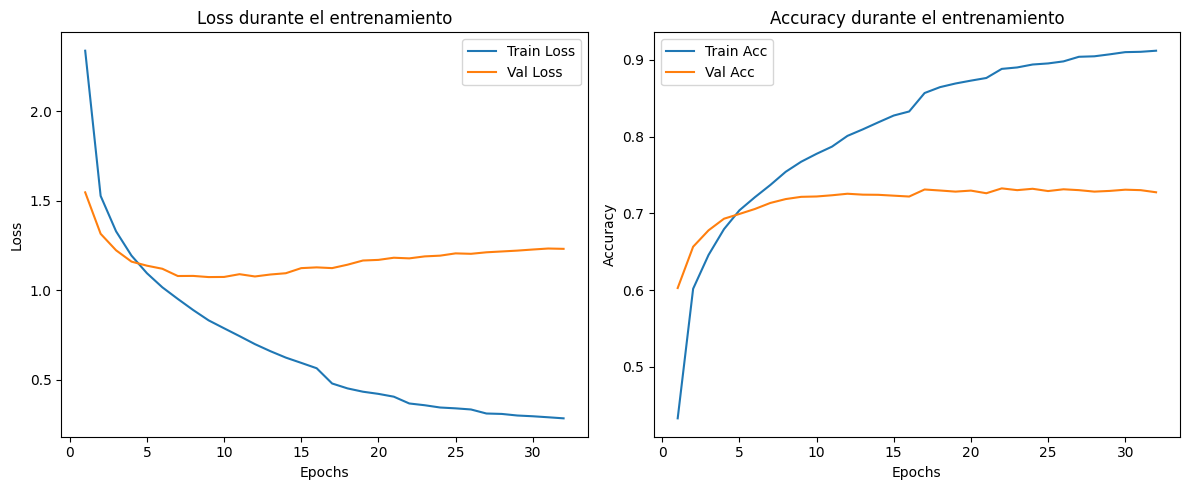

Tiempo inferencia Student
⏱️ Tiempo de inferencia promedio por imagen: 8.895 ms


In [13]:
#sTUDENT CLASICO
with open("historial_student_classic_food3.pkl", "rb") as f:
    history_student = pickle.load(f)   

# Modelo Student
print('sTUDENT CLASICO')
visualizar_curvas(history_student)    

print('Tiempo inferencia Student')
tiempo_mobilenet = medir_inferencia(modelo_student_clasico, test_loader, device)

Visualizar métricas adicionales, evaluación del modelo y matriz de confusión

Evaluar modelo sTUDENT en test
📊 Clasification Report:
                         precision    recall  f1-score   support

              apple_pie       0.56      0.54      0.55        50
         baby_back_ribs       0.80      0.72      0.76        50
                baklava       0.80      0.86      0.83        50
         beef_carpaccio       0.77      0.74      0.76        50
           beef_tartare       0.63      0.74      0.68        50
             beet_salad       0.62      0.58      0.60        50
               beignets       0.85      0.78      0.81        50
               bibimbap       0.80      0.88      0.84        50
          bread_pudding       0.55      0.58      0.56        50
      breakfast_burrito       0.59      0.52      0.55        50
             bruschetta       0.68      0.60      0.64        50
           caesar_salad       0.77      0.80      0.78        50
                cannoli       0.80      0.74      0.77        50
          caprese_salad       0.68

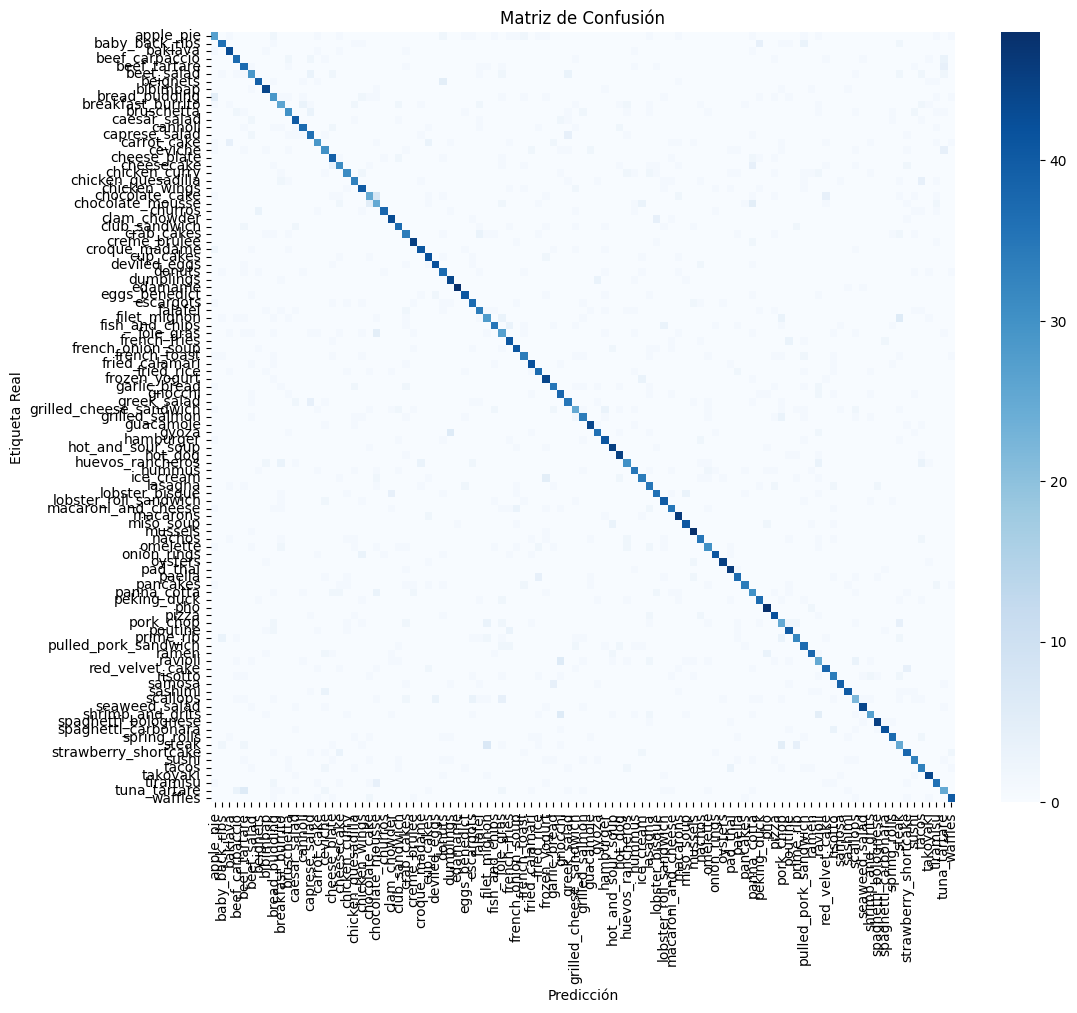

In [9]:
# Evaluar modelo sTUDENT en test
print('Evaluar modelo sTUDENT en test')
evaluar_modelo(modelo_student_clasico, test_loader, class_names, device)

### CONCLUSIÓN – Entrenamiento del modelo Student (MobileNetV3 Small, Caso 3)

Los resultados alcanzados en el entrenamiento final muestran las **limitaciones y fortalezas del modelo Student clásico**.  
Las curvas de entrenamiento evidencian que, aunque la pérdida en entrenamiento disminuye de manera constante, la validación tiende a estabilizarse tempranamente, lo que indica una capacidad limitada de generalización frente al conjunto de validación.  

El modelo alcanzó un **accuracy promedio del 73% y un macro-F1 también de 0.73**, valores que reflejan un desempeño aceptable para un modelo ligero, pero claramente inferior al obtenido por el modelo Teacher. La **matriz de confusión** confirma esta tendencia, mostrando un mayor nivel de errores dispersos entre distintas clases, en especial en categorías visualmente más similares.  

Un aspecto positivo es el **tiempo de inferencia**, con un promedio de apenas **8.9 ms por imagen**, lo que demuestra que el modelo es altamente eficiente para su ejecución en dispositivos con recursos limitados. Esta rapidez confirma que, a pesar de sacrificar precisión, el Student clásico es una alternativa viable en escenarios donde la velocidad y el bajo consumo de recursos son prioritarios.  

En conjunto, estos resultados permiten concluir que el **MobileNetV3 Small entrenado de forma clásica ofrece eficiencia en inferencia pero con limitaciones significativas en precisión**, dejando en evidencia la necesidad de aplicar técnicas adicionales, como la **Knowledge Distillation (KD)**, para optimizar el balance entre rendimiento predictivo y eficiencia en entornos reales.
